In [73]:
import numpy as np
import pandas as pd
import yfinance as yf

def implied_correlation(v_idx, v_stocks, w):
    """
    Compute implied average correlation from option-implied variances.
    """
    v_stocks = np.array(v_stocks)
    w = np.array(w)

    numerator = v_idx - np.sum((w**2) * v_stocks)
    denominator = 2 * np.sum([
        w[i] * w[j] * np.sqrt(v_stocks[i] * v_stocks[j])
        for i in range(len(v_stocks)) for j in range(i+1, len(v_stocks))
    ])

    return numerator / denominator


def realized_variance(returns):
    """Annualized realized variance from daily returns."""
    return np.var(returns, ddof=1) * 252


def realized_correlation(stock_returns, weights):
    """Compute realized average correlation between stock returns."""
    cov = stock_returns.cov() * 252  # annualized covariance matrix
    vols = np.sqrt(np.diag(cov))

    # Index variance from stocks
    v_idx = weights @ cov.values @ weights
    v_stocks = vols**2

    numerator = v_idx - np.sum((weights**2) * v_stocks)
    denominator = 2 * np.sum([
        weights[i] * weights[j] * vols[i] * vols[j]
        for i in range(len(vols)) for j in range(i+1, len(vols))
    ])

    return numerator / denominator


def dispersion_pnl(v_idx_impl, v_idx_real, v_stocks_impl, v_stocks_real, w):
    """
    Approximate dispersion P&L (variance swap style).
    Long single-stock variance, short index variance.
    """
    stock_leg = np.sum((w**2) * (v_stocks_real - v_stocks_impl))
    index_leg = (v_idx_real - v_idx_impl)
    return stock_leg - index_leg

In [74]:
# Download some historical prices
tickers = ["SPY", "AAPL", "MSFT", "AMZN"]
data = yf.download(tickers, start="2018-01-01", end="2020-01-01",auto_adjust = False)

adj_close = data["Adj Close"].copy()
adj_close = adj_close[["SPY","AAPL","MSFT","AMZN"]]  # enforce order
print(adj_close)

# Compute returns
returns = adj_close.pct_change().dropna()


# Weights (approximate SPY weights for AAPL/MSFT/AMZN subset)
weights = np.array([0.07, 0.06, 0.04])  # AAPL, MSFT, AMZN in SP500

import numpy as np

def ensure_normalized(weights):
    w = np.array(weights, dtype=float)
    s = w.sum()
    if s == 0:
        raise ValueError("Weights sum to zero.")
    if abs(s - 1.0) > 1e-8:
        w = w / s
    return w

weights = ensure_normalized(weights)


# Normally you'd get these from option chains
sigma_idx_impl = 0.20  # 20% implied vol for SPY
sigma_stocks_impl = np.array([0.25, 0.22, 0.28])  # toy vols for AAPL, MSFT, AMZN

# Convert to variances
v_idx_impl = sigma_idx_impl**2
v_stocks_impl = sigma_stocks_impl**2

[*********************100%***********************]  4 of 4 completed

Ticker             SPY       AAPL        MSFT       AMZN
Date                                                    
2018-01-02  238.568726  40.380993   79.198326  59.450500
2018-01-03  240.077728  40.373962   79.566895  60.209999
2018-01-04  241.089569  40.561504   80.267212  60.479500
2018-01-05  242.696289  41.023296   81.262367  61.457001
2018-01-08  243.140060  40.870941   81.345306  62.343498
...                ...        ...         ...        ...
2019-12-24  296.051758  68.654976  149.709061  89.460503
2019-12-26  297.627686  70.017113  150.936188  93.438499
2019-12-27  297.553864  69.990532  151.212051  93.489998
2019-12-30  295.913574  70.405937  149.908798  92.344498
2019-12-31  296.632385  70.920364  150.013428  92.391998

[503 rows x 4 columns]


In [75]:
#calc implied correlation
rho_impl = implied_correlation(v_idx_impl, v_stocks_impl, weights)

# Realized variances
v_idx_real = realized_variance(returns["SPY"])
v_stocks_real = [realized_variance(returns[t]) for t in ["AAPL","MSFT","AMZN"]]
rho_real = realized_correlation(returns[["AAPL","MSFT","AMZN"]], weights)

pnl = dispersion_pnl(v_idx_impl, v_idx_real, v_stocks_impl, v_stocks_real, weights)

In [76]:
def cash_pnl_from_variance(delta_v, N_var):
    """delta_v = v_real - v_impl (variance units), N_var = $ per 1.0 variance"""
    return delta_v * N_var

def required_Nvar_for_target_per_vol(target_dollars_per_volpoint, sigma):
    """
    Solve N_var so that a 1 percentage-point (=0.01) vol move produces target_dollars_per_volpoint.
    Uses linear approx: delta_v ≈ 2*sigma*delta_sigma with delta_sigma=0.01
    """
    delta_sigma = 0.01
    delta_v_per_1pct = 2 * sigma * delta_sigma
    return target_dollars_per_volpoint / delta_v_per_1pct

# Example values:
delta_v = pnl            # your dispersion output
N_var = 10_000_000          # $10M per variance-point
print("Cash P&L = $", cash_pnl_from_variance(delta_v, N_var))

sigma = 0.20                # 20% base vol
target_per_1pct = 100_000   # want $100k per 1% vol move
print("Required N_var = $", required_Nvar_for_target_per_vol(target_per_1pct, sigma))

Cash P&L = $ 219589.57681820827
Required N_var = $ 25000000.0


=== Dispersion Dashboard ===
Implied correlation:  0.478
Realized correlation: 0.673
Variance P&L:         0.0220
Cash P&L (@N_var=10,000,000): $219,590


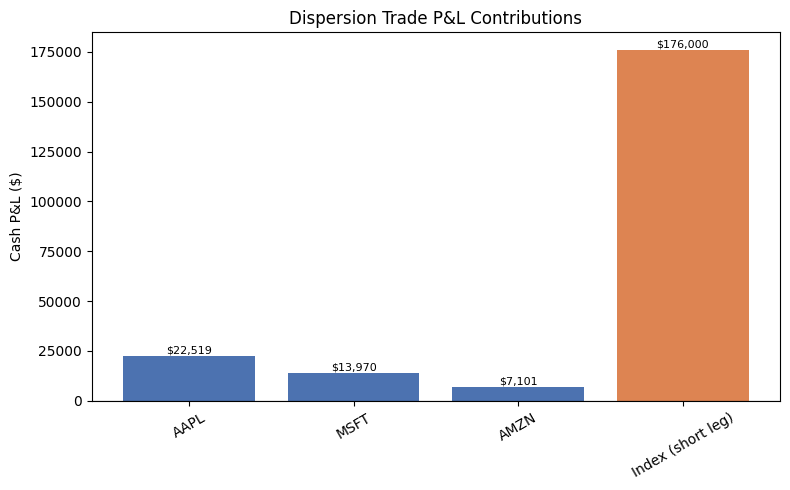

(np.float64(0.4784548743998331),
 np.float64(0.6727717899234139),
 np.float64(0.021958957681820827),
 np.float64(219589.57681820827),
 [np.float64(22519.123550140826),
  np.float64(13969.911561411209),
  np.float64(7100.925524575725),
  175999.61618208053])

In [77]:
import matplotlib.pyplot as plt

def dispersion_dashboard(idx_impl_vol, stock_impl_vols, weights, returns, N_var):
    """
    Compute dispersion metrics and show P&L contributions.
    """
    w = np.array(weights)
    v_idx_impl = idx_impl_vol**2
    v_stocks_impl = np.array(stock_impl_vols)**2

    # Implied correlation
    rho_impl = implied_correlation(v_idx_impl, v_stocks_impl, w)

    # Realized variances
    v_idx_real = realized_variance(returns.iloc[:,0])  # assume first col = index
    v_stocks_real = [realized_variance(returns[c]) for c in returns.columns[1:]]
    rho_real = realized_correlation(returns.iloc[:,1:], w)

    # Dispersion variance P&L
    stock_leg_pnls = w**2 * (np.array(v_stocks_real) - v_stocks_impl)
    index_leg_pnl = -(v_idx_real - v_idx_impl)
    pnl_var = stock_leg_pnls.sum() + index_leg_pnl
    pnl_cash = pnl_var * N_var

    #dispersion summary
    print("=== Dispersion Dashboard ===")
    print(f"Implied correlation:  {rho_impl:.3f}")
    print(f"Realized correlation: {rho_real:.3f}")
    print(f"Variance P&L:         {pnl_var:.4f}")
    print(f"Cash P&L (@N_var={N_var:,.0f}): ${pnl_cash:,.0f}")

    #plot
    labels = list(returns.columns[1:]) + ["Index (short leg)"]
    contributions = list(stock_leg_pnls * N_var) + [index_leg_pnl * N_var]

    plt.figure(figsize=(8,5))
    bars = plt.bar(labels, contributions, color=["#4c72b0"]*len(stock_leg_pnls)+["#dd8452"])
    plt.axhline(0, color="black", linewidth=0.8)
    plt.title("Dispersion Trade P&L Contributions")
    plt.ylabel("Cash P&L ($)")
    plt.xticks(rotation=30)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f"${yval:,.0f}",
                 ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

    return rho_impl, rho_real, pnl_var, pnl_cash, contributions

dispersion_dashboard(sigma_idx_impl, sigma_stocks_impl, weights, returns, N_var)


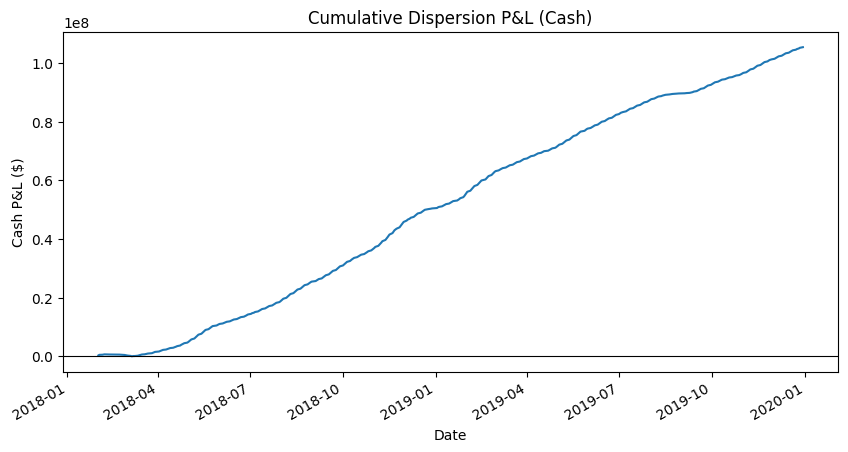

In [78]:
def rolling_dispersion_pnl(returns, idx_impl_vol, stock_impl_vols, weights, N_var, window=21):
    """
    Compute rolling dispersion trade P&L over time.
    """
    w = np.array(weights) / np.sum(weights)
    v_idx_impl = idx_impl_vol**2
    v_stocks_impl = np.array(stock_impl_vols)**2

    pnl_list = []
    dates = []

    for start in range(len(returns)-window):
        sub = returns.iloc[start:start+window]

        # realized variances over this window
        v_idx_real = realized_variance(sub.iloc[:,0])
        v_stocks_real = [realized_variance(sub[c]) for c in sub.columns[1:]]

        # variance pnl
        pnl_var = dispersion_pnl(v_idx_impl, v_idx_real, v_stocks_impl, v_stocks_real, w)
        pnl_cash = pnl_var * N_var

        pnl_list.append(pnl_cash)
        dates.append(sub.index[-1])

    pnl_series = pd.Series(pnl_list, index=dates)
    return pnl_series

# Example run
pnl_series = rolling_dispersion_pnl(
    returns[["SPY","AAPL","MSFT","AMZN"]],
    idx_impl_vol=0.20,
    stock_impl_vols=[0.25,0.22,0.28],
    weights=[0.07,0.06,0.04],
    N_var=10_000_000
)

plt.figure(figsize=(10,5))
pnl_series.cumsum().plot()
plt.title("Cumulative Dispersion P&L (Cash)")
plt.ylabel("Cash P&L ($)")
plt.xlabel("Date")
plt.axhline(0, color="black", linewidth=0.8)
plt.show()
